In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Cabin needs to be parsed. 

```
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
```

Name and PassengerId are not suitable as features.

In [4]:
cat_features = ["HomePlanet", 'CryoSleep', 'Destination', 'VIP',]
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
id_columns = ['PassengerId', 'Name']
target_column = 'Transported'

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train[cat_features + num_features], 
    train[target_column], 
    test_size=0.1,
    random_state=2320
)
X_train_all = train[cat_features + num_features]
y_train_all = train[target_column]
X_test = test[cat_features + num_features]

print(f"Train size: {X_train.shape[0]:}")
print(f"Validation size: {X_val.shape[0]:}")


Train size: 7823
Validation size: 870


In [6]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb

A baseline model has all steps required from data preprocessing building to model evaluation. The model itself is simple to build and fast to train. It should not need to take complicated features or advanced tuning. The purpose of a baseline model is to serve a blueprint for the following model improvement iterations. In addition the performance of the baseline model is also used to benchmark the following model tuning.

Here we fit a baseline model using XGBClassifier with minimal hyperparameter tuning to find a reasonable values for n_estimators and learning_rate.

In [17]:
# Build pipeline
ct = ColumnTransformer([
    ('num_features', 'passthrough', num_features),
    ('cat_features', OneHotEncoder(), cat_features),
])
baseline_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=400,
    learning_rate=0.01,
    eval_metric="logloss"
)
eval_set = [(X_train, y_train)]
baseline_pipeline = Pipeline([
    ("ct", ct),
    ("clf", baseline_clf)
])

In [18]:
set_config(display='diagram')
baseline_pipeline

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_features', 'passthrough',
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_features',
                                                  OneHotEncoder(),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsampl...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

In [19]:
set_config(display="text")

In [20]:
# Preprocess X_train before it is passed to XGB eval_set
X_train_trans = baseline_pipeline[:-1].fit_transform(X_train)
X_val_trans = baseline_pipeline[:-1].fit_transform(X_val)

# Fit the baseline pipeline
baseline_pipeline.fit(
    X=X_train, y=y_train, 
    clf__eval_set=[(X_train_trans, y_train), (X_val_trans, y_val)],
    clf__verbose=100
)

[0]	validation_0-logloss:0.68892	validation_1-logloss:0.68912
[100]	validation_0-logloss:0.48225	validation_1-logloss:0.49680
[200]	validation_0-logloss:0.42587	validation_1-logloss:0.44698
[300]	validation_0-logloss:0.40152	validation_1-logloss:0.43028
[399]	validation_0-logloss:0.38860	validation_1-logloss:0.42565


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_features', 'passthrough',
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_features',
                                                  OneHotEncoder(),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])])),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_b...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
    

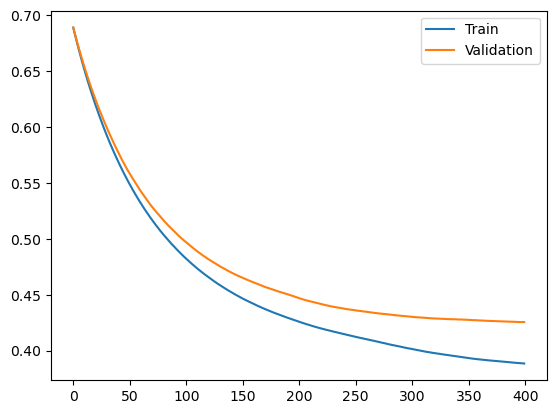

In [21]:
# Convergence
results = baseline_pipeline[1].evals_result()
plt.plot(results["validation_0"]["logloss"], label="Train")
plt.plot(results["validation_1"]["logloss"], label="Validation")
plt.legend()

In [22]:
# Prediction
y_val_pred = baseline_pipeline.predict(X_val)
y_train_pred = baseline_pipeline.predict(X_train)
# Metrics
print("Accuracy: Validation - {:.2f} | Train - {:.2f}".format(accuracy_score(y_val, y_val_pred), accuracy_score(y_train, y_train_pred)))
print()
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

Accuracy: Validation - 0.80 | Train - 0.82

Confusion Matrix:
[[3010  850]
 [ 551 3412]]


Build a new pipeline for grid search. By default, parameter search uses the score function of the estimator to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression.

The grid search takes 50 minutes to test 216 hyper-parameter combinations and 5-fold Stratified Cross Validation (target is strata). In total 1080 models were built. RandomizedSearchCV or Bayesian Hyperparameter Tuning should be more efficient.

Bayesian Hyperparameter Tuning
https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

In [29]:
# Pipeline
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_pipeline = Pipeline([
    ("ct", ct),
    ("clf", xgb_model)
])
# Param grid
param_grid = {
    "clf__n_estimators":[100, 200, 500, 1000],
    "clf__max_depth":[4, 6, 8],
    "clf__eta":[0.01, 0.001],
    "clf__subsample": [0.4, 0.8, 1],
    "clf__colsample_bytree": [0.6, 0.8, 1],
    "clf__reg_alpha": [0],
    "clf__reg_lambda": [1],
    "clf__min_split_loss":[0]
}
# The scoring parameter is not set
xgb_clf = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=5, refit=True, verbose=3, n_jobs=4, )
xgb_clf.fit(X_train_all, y_train_all)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[19:56:43] WARNING: ../src/learner.cc:627: 
Parameters: { "reg_gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END clf__colsample_bytree=0.6, clf__eta=0.01, clf__max_depth=4, clf__min_split_loss=0, clf__n_estimators=100, clf__reg_alpha=0, clf__reg_gamma=1, clf__subsample=0.4; total time=   1.6s
[19:56:44] WARNING: ../src/learner.cc:627: 
Parameters: { "reg_gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END clf__colsample_by

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_features',
                                                                         'passthrough',
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck']),
                                                                        ('cat_features',
                                                                         OneHotEncoder(),
                                                                 

The best model is not better than the baseline model. 

In [40]:
print(f"Best Validation Score: {xgb_clf.best_score_:.2f}")
print("Best Parameters:")
print(xgb_clf.best_params_)
print("Best Estimator:")
print(xgb_clf.best_estimator_)

Best Validation Score: 0.80
Best Parameters:
{'clf__colsample_bytree': 1, 'clf__eta': 0.001, 'clf__max_depth': 8, 'clf__min_split_loss': 0, 'clf__n_estimators': 1000, 'clf__reg_alpha': 0, 'clf__reg_gamma': 1, 'clf__subsample': 0.4}
Best Estimator:
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_features', 'passthrough',
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_features',
                                                  OneHotEncoder(),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])])),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               

In [37]:
# Save all results for future reference 
cv_results = pd.DataFrame(xgb_clf.cv_results_).sort_values("rank_test_score")
# cv_results.to_csv("/kaggle/working/xgb_cv_results.csv", index=False)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bytree,param_clf__eta,param_clf__max_depth,param_clf__min_split_loss,param_clf__n_estimators,param_clf__reg_alpha,...,param_clf__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
213,32.282338,0.165239,0.130673,0.003240,1,0.001,8,0,1000,0,...,0.4,"{'clf__colsample_bytree': 1, 'clf__eta': 0.001...",0.798735,0.791259,0.797010,0.814154,0.808976,0.802027,0.008334,1
168,3.309409,0.097886,0.025749,0.000544,1,0.01,8,0,100,0,...,0.4,"{'clf__colsample_bytree': 1, 'clf__eta': 0.01,...",0.796435,0.788959,0.798735,0.814154,0.810702,0.801797,0.009327,2
96,2.907408,0.168670,0.025872,0.000320,0.8,0.01,8,0,100,0,...,0.4,"{'clf__colsample_bytree': 0.8, 'clf__eta': 0.0...",0.797010,0.789534,0.799885,0.810702,0.810702,0.801567,0.008189,3
171,6.444145,0.040887,0.036858,0.000443,1,0.01,8,0,200,0,...,0.4,"{'clf__colsample_bytree': 1, 'clf__eta': 0.01,...",0.797585,0.790684,0.798160,0.807825,0.810702,0.800991,0.007306,4
163,13.785177,0.199273,0.052355,0.003552,1,0.01,6,0,500,0,...,0.8,"{'clf__colsample_bytree': 1, 'clf__eta': 0.01,...",0.797010,0.792984,0.793560,0.809551,0.810127,0.800646,0.007633,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,2.935683,0.010736,0.023289,0.000220,0.6,0.001,4,0,200,0,...,1,"{'clf__colsample_bytree': 0.6, 'clf__eta': 0.0...",0.763082,0.768258,0.748706,0.787112,0.787112,0.770854,0.014740,212
181,2.002585,0.007555,0.019542,0.000311,1,0.001,4,0,100,0,...,0.8,"{'clf__colsample_bytree': 1, 'clf__eta': 0.001...",0.756182,0.759632,0.768258,0.789413,0.779056,0.770508,0.012321,213
185,3.967499,0.239536,0.024252,0.002495,1,0.001,4,0,200,0,...,1,"{'clf__colsample_bytree': 1, 'clf__eta': 0.001...",0.749856,0.759057,0.768258,0.791715,0.773878,0.768553,0.014175,214
38,1.511969,0.010453,0.019777,0.000358,0.6,0.001,4,0,100,0,...,1,"{'clf__colsample_bytree': 0.6, 'clf__eta': 0.0...",0.757907,0.766532,0.746406,0.782509,0.785961,0.767863,0.014855,215


In [33]:
best_clf = xgb_clf.best_estimator_

In [41]:
best_clf.predict_proba(X_test)

array([[0.42995924, 0.57004076],
       [0.7892522 , 0.21074778],
       [0.19208205, 0.80791795],
       ...,
       [0.2505328 , 0.7494672 ],
       [0.4247328 , 0.5752672 ],
       [0.4867823 , 0.5132177 ]], dtype=float32)